In [ ]:
# 2.3.1. Загрузка данных и первичный анализ

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, 
                             confusion_matrix, classification_report,
                             roc_curve, RocCurveDisplay)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('S05-hw-dataset.csv')  

# 1. Первые строки
print("Первые 5 строк датасета:")
print(df.head())
print("\n" + "="*80)

# 2. Информация о столбцах и типах данных
print("\nИнформация о датасете:")
print(df.info())
print("\n" + "="*80)

# 3. Описательные статистики для числовых признаков
print("\nБазовые описательные статистики (describe):")
print(df.describe())
print("\n" + "="*80)

# 4. Распределение целевого признака 'default'
print("\nРаспределение целевой переменной 'default':")
target_distribution = df['default'].value_counts(normalize=True) * 100
print(target_distribution)
print(f"Всего объектов: {len(df)}")
print(f"Всего признаков (включая таргет): {df.shape[1]}")

Первые 5 строк датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229        

In [ ]:
# 2.3.2. Подготовка признаков и таргета

X = df.drop(columns=['client_id', 'default'])
y = df['default']

print(f"Размерность матрицы признаков X: {X.shape}")
print(f"Размерность вектора таргета y: {y.shape}")

print("\nТипы данных в X:")
print(X.dtypes)

print(f"\nДиапазон debt_to_income: от {X['debt_to_income'].min():.2f} до {X['debt_to_income'].max():.2f}")

Размерность матрицы признаков X: (3000, 15)
Размерность вектора таргета y: (3000,)

Типы данных в X:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

Диапазон debt_to_income: от 0.01 до 0.88


In [ ]:
# 2.3.3. Train/Test-сплит и бейзлайн-модель

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        
    random_state=42,    
    stratify=y           
)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)
y_pred_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1] 

dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_roc_auc = roc_auc_score(y_test, y_pred_proba_dummy)

print("\n--- Оценка бейзлайн-модели (DummyClassifier) ---")
print(f"Accuracy: {dummy_accuracy:.4f}")
print(f"ROC-AUC:  {dummy_roc_auc:.4f}")

Размер обучающей выборки: (2400, 15)
Размер тестовой выборки: (600, 15)

--- Оценка бейзлайн-модели (DummyClassifier) ---
Accuracy: 0.5900
ROC-AUC:  0.5000
(Бейзлайн всегда предсказывает самый частый класс в обучающих данных)



--- Лучшие параметры логистической регрессии ---
{'logreg__C': 100.0, 'logreg__penalty': 'l2'}
Лучший ROC-AUC на кросс-валидации: 0.8607

--- Оценка логистической регрессии на тестовой выборке ---
Accuracy: 0.8017
ROC-AUC:  0.8756

Отчёт о классификации:
              precision    recall  f1-score   support

  No Default       0.81      0.88      0.84       354
     Default       0.80      0.70      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.80      0.80       600

Матрица ошибок (Confusion Matrix):
[[310  44]
 [ 75 171]]
ROC-кривая сохранена в 'figures/roc_curve.png'


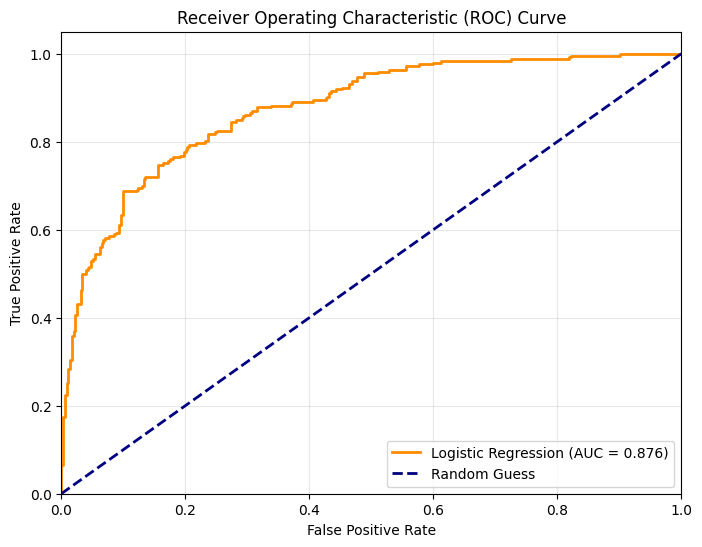

In [8]:
# 2.3.4. Логистическая регрессия и подбор гиперпараметров

pipe = Pipeline([
    ('scaler', StandardScaler()),          # Стандартизация данных
    ('logreg', LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'))
])

# Задаем сетку параметров для перебора
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0], 
    'logreg__penalty': ['l2']  
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
)

# Обучение модели с подбором параметров
grid_search.fit(X_train, y_train)

#Лучшая модель
best_model = grid_search.best_estimator_
print(f"\n--- Лучшие параметры логистической регрессии ---")
print(grid_search.best_params_)
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

#Оценка лучшей модели на тестовой выборке
y_pred_logreg = best_model.predict(X_test)
y_pred_proba_logreg = best_model.predict_proba(X_test)[:, 1]

logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)

print("\n--- Оценка логистической регрессии на тестовой выборке ---")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"ROC-AUC:  {logreg_roc_auc:.4f}")
print("\nОтчёт о классификации:")
print(classification_report(y_test, y_pred_logreg, target_names=['No Default', 'Default']))
print("Матрица ошибок (Confusion Matrix):")
print(confusion_matrix(y_test, y_pred_logreg))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logreg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {logreg_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/roc_curve.png', dpi=150, bbox_inches='tight')
print("ROC-кривая сохранена в 'figures/roc_curve.png'")
plt.show()

# Сравнение капчества моделей
DummyClassifier, предсказывает самый частый класс, показала accuracy 0.59, что соответствует доле класса majority в данных. *НО* ее ROC_AUC равен 0.5, что можно назвать случайным угадыванием
# Улучшение метрик 
Логистическая регрессия значительно превзошла бэйзлайн(DummyClassifier) по двум метрикам, Accuracy выросла с 0.59 до 0.8017, а самое главное вырос ROC_AUC с 0.5 до 0.8756, что говорт о том что модель способна хорошо различать клиентов с дефолтом и без него 
# выводы
- Логистическая регрессия является правильным вариантом решения данной задачи, так как показывает показатели лучше чем бэйзлайн.
- ROC_AUC равное 0.8756 доказывает нам, что модель не просто угадывает, а реально способна находить закономернности в данных, что и позволяет давать правильные ответы.